This notebook adds an additional ranking to the NOVOZYMES' thermostability prediction based on the average Root Mean Square Deviation (RMSD) per residue computed from the trajectory of a Molecular Dynamics (MD) simulation carried out through the VMD and NAMD software, following the official NAMD tutorial with some minor differences:
* http://www.ks.uiuc.edu/Training/Tutorials/namd/namd-tutorial-unix.pdf

The VMD and NAMD software can be downloaded free of charge at the following links:
* https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD
* https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=NAMD

# Notes

* **Version 2** uses half the simulation time as version 1.
* It is advisable to restart VMD and reload the input files after every single calculation because sometimes the variables in memory to change value (e.g. calculating the RMSD twice consecutively does not given the same result).

# Pre-processing

We start by loading the PDB file provided by the organizers through VMD with the following command in a terminal:

```
vmd wildtype_structure_prediction_af2.pdb
```

The protein is shown below in cartoon representation colored by secondary structure:

<img src="https://i.imgur.com/YESYWwq.png">

Next we need to generate the Protein Structure File (PSF). In the "VMD Main" window click on "Extensions" and then on "Tk Console". Then paste the following TCL scripts within the Tk Console.

First we make sure that only protein atoms are to be used:

```
set af2 [atomselect top protein] 
$af2 writepdb af2.pdb 
```

Next we load the "psfgen" package and run it using the "top_all27_prot_lipid.inp" CHARMM22 topology file which is provided in the "1-1-build" directory of the tutorial. This file contains the atomic masses and partial charges which are residue-specific:

```
package require psfgen 
topology top_all27_prot_lipid.inp 
pdbalias residue HIS HSE 
pdbalias atom ILE CD1 CD 
segment U {pdb af2.pdb} 
coordpdb af2.pdb U 
guesscoord 
writepdb af2o.pdb 
writepsf af2o.psf 
```

Now we add water molecules within a cubic box, including 5Å of padding in each direction:

```
package require solvate 
solvate af2o.psf af2o.pdb -t 5 -o af2o_wb 
```

We could also add salt in physiological concentration, although my understanding is that the actual salt concentration of this enzyme under industrial conditions might differ significantly, which is why I skipped this step for the moment:

```
package require autoionize 
autoionize -psf af2o_wb.psf -pdb af2o_wb.pdb -sc 0.15 -o af2o_wb_ion 
```

Finally, we need to measure the center and dimensions of the water box:

```
set everyone [atomselect top all]
measure minmax $everyone
measure center $everyone
```

The result is a box centered at (4.31, 0.9, 13.4) with dimensions of 74 in X, 53 in Y and 87 in Z:

<video controls>
<source src="https://i.imgur.com/TDLApPv.mp4">
</video>


# Simulation

A 100 picosecond simulation was run in a local computer using 16 cores through the "namd2" program:

```
namd2 +p16 af2.conf > af2.log &
```

<video controls>
<source src="https://i.imgur.com/AJOuHHg.mp4">
</video>

The file "af2.conf" included in the uploads was taken from the "ubq_wb_eq.conf" file from the "1-3-box" directory of the tutorial with a few modifications, mainly:
1. The "Periodic Boundary Conditions" need to be set from the values recorded in the pre-processing step:
```
# Periodic Boundary Conditions
cellBasisVector1    74.0    0.   0.0
cellBasisVector2     0.0  53.0   0.0
cellBasisVector3     0.0    0   87.0
cellOrigin          4.31   0.9  13.4
```
2. The minimization and equilibration steps were increased to 1000 and 50000 respectively.

The only additional input file needed is the "par_all27_prot_lipid.inp" CHARMM22 parameter file located in the "common" directory of the tutorial. This file contains the atomic force-field empirical parameters necessary for the calculation of atomic forces.

# Analysis

The VMD software allows for many interesting forms of analysis. In this competition, it seemed like the root mean squared deviaton (RMSD) would be the most relevant analysis since it directly measures the stability of a residue's structure. Basically, if a residue's RMSD is very small (i.e. it moves very little), that means that this residue is very stable in its current location and therefore if it were to be mutated, the new mutated residue might not be as stable as the original one. Such mutated residue should thus be more likely to have a low thermostability ranking.

In order to analyze the trajectory, we load the PSF and DCD trajectory files into VMD:
```
vmd af2o_wb.psf af2o_wb.dcd
```

We can then measure the RMSD of the whole protein by pasting the script presented in the tutorial into the Tk Console:
```
set outfile [open rmsd.dat w]
set nf [molinfo top get numframes]
set frame0 [atomselect top "protein and backbone and noh" frame 0]
set sel [atomselect top "protein and backbone and noh"]
for { set i 1 } { $i <= $nf } { incr i } {
$sel frame $i
$sel move [measure fit $sel $frame0]
puts $outfile "[measure rmsd $sel $frame0]"
}
close $outfile
```

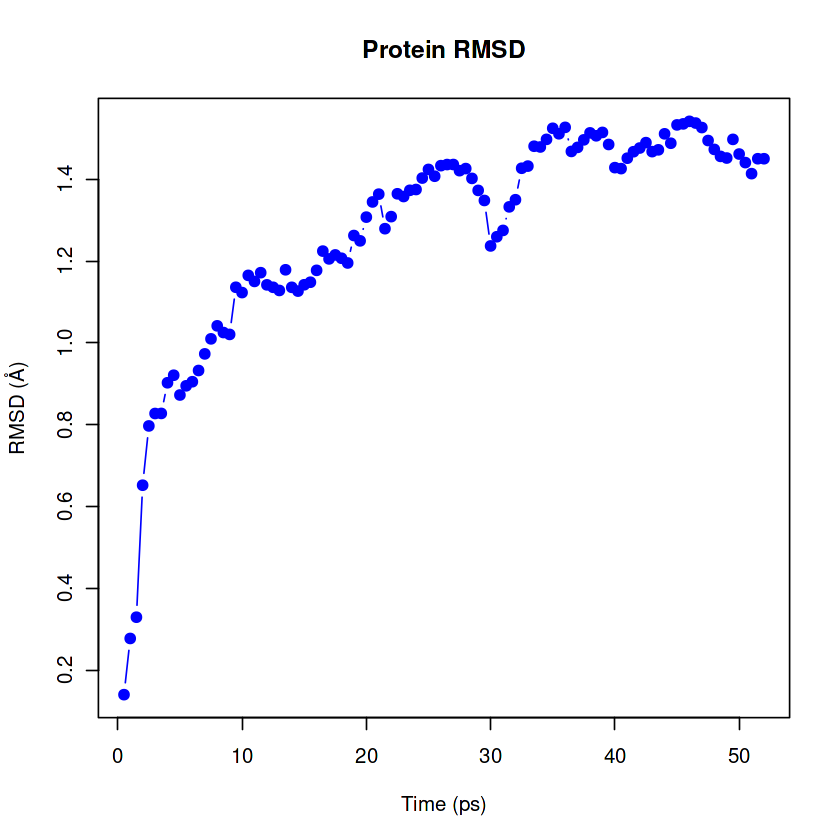

In [1]:
# Read full-protein (excluding hydrogen atoms) RMSD vs time:
library(ggplot2)
rmsd <- read.table('../input/novozymes-md2/rmsd.dat',header=F)
plot(
    c(1:dim(rmsd)[1])/2, rmsd[,1], type="b", pch=19, col="blue", 
    xlab="Time (ps)", ylab="RMSD (Å)", main="Protein RMSD"
)

We can also get the RMSD for each residue through the "residue_rmsd.tcl" file provided in the "2-1-rmsd" directory of the tutorial, with some minor differences:
* Change all "frame 0" by "frame "last"" in order to measure the RMSD relative to the last frame of the simulation (under equilibrium conditions) rather than the first frame (i.e. the original structure in the PDB file).
* Add the solvent-accessible surface-area (SASA) of the first and of the last frames:
```
# SASA using first frame:
set selprot [atomselect top "protein" frame 0]
set selres [atomselect top "protein and resid $r" frame 0]
set sasafirst [measure sasa 1.4 $selprot -restrict $selres]
# SASA using last frame:
set selprot [atomselect top "protein" frame "last"]
set selres [atomselect top "protein and resid $r" frame "last"]
set sasalast [measure sasa 1.4 $selprot -restrict $selres]
# print the RMSD
puts "RMSD of residue $r is $rmsd($r)"
puts $fil " $r \t $rmsd($r) \t $sasafirst \t $sasalast"
```

We need to restart VMD and reload the PSF and DCD files every time we do a calculation:
```
vmd af2o_wb.psf af2o_wb.dcd
```

Next we paste the TCL script below into the TK Console in order to generate the "residue_rmsd_sasa_last.dat" file:
```
source residue_rmsd_last.tcl
set sel_resid [[atomselect top "protein and alpha"] get resid]
rmsd_residue_over_time top $sel_resid
```

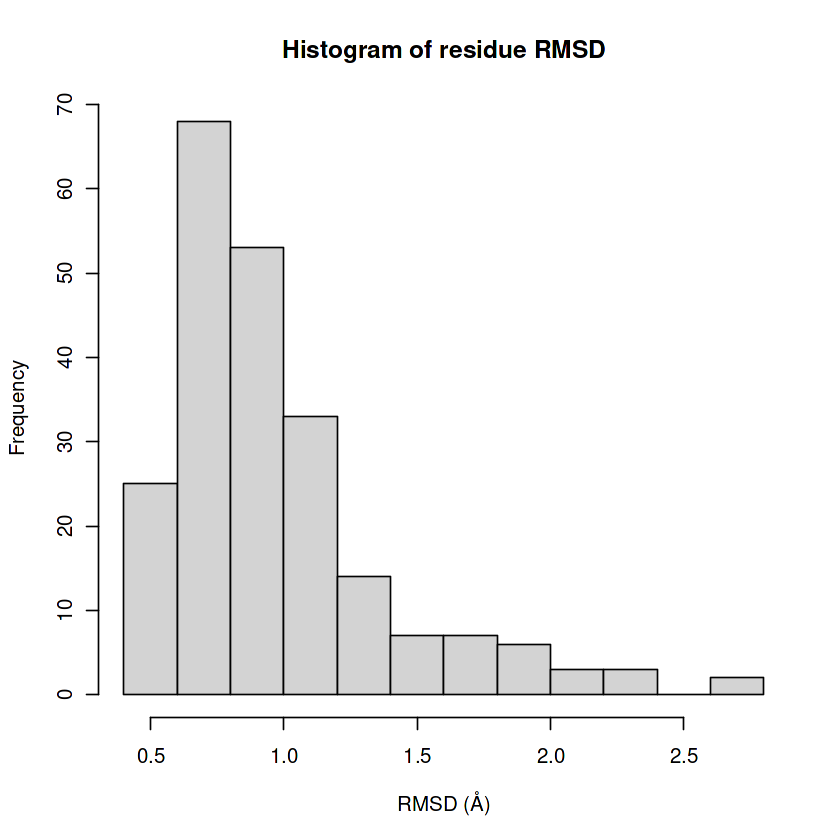

In [2]:
# Read VMD/NAMD output:
namd <- read.table('../input/novozymes-md2/residue_rmsd_sasa_last.dat',header=F)
colnames(namd) <- c('resid','rmsd','sasa0','sasaf')
hist(namd$rmsd, xlab="RMSD (Å)", main="Histogram of residue RMSD")

# Submissions

We simply get the residue ID of the mutated residue (or -1 if there is no mutation) and use it to merge with the residue's RMSD. Since the wild-type has no mutation, we give it the minimum RMSD:

In [3]:
# Wild type sequence provided in the "Dataset Description":
wtseq <- 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Read testing set and find the id of the mutated residue:
test <- read.csv('../input/novozymes-enzyme-stability-prediction/test.csv')
test$resid <- sapply(test$protein_sequence,function(seq){
  if(seq==wtseq){ return(-1) } else {
    wtsub <- substr(wtseq,1,nchar(seq))
    i <- mapply(function(x,y) which(x!=y)[1], strsplit(seq,""), strsplit(wtsub,""))
    return(i)
  }
})

# Add VMD/NAMD results to the testing set:
test <- merge(test,namd,all.x=T)
test[test$resid==-1,'rmsd'] <- min(test$rmsd,na.rm=T) #wild-type
test <- test[order(test$seq_id),]
      
# RMSD-only submission:
test$tm <- rank(test$rmsd)
write.csv(test[,c('seq_id','tm')],file='submission_rmsd.csv',row.names=FALSE,quote=FALSE)

# SASA-first submission:
test$tm <- rank(test$sasa0)
write.csv(test[,c('seq_id','tm')],file='submission_sasa0.csv',row.names=FALSE,quote=FALSE)

# SASA-last submission:
test$tm <- rank(test$sasaf)
write.csv(test[,c('seq_id','tm')],file='submission_sasaf.csv',row.names=FALSE,quote=FALSE)
      
head(test)

,resid,seq_id,protein_sequence,pH,data_source,rmsd,sasa0,sasaf,tm
,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
12,17,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.713078,173.45062,186.3791,2374.0
13,17,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.713078,173.45062,186.3791,2374.0
14,17,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.713078,173.45062,186.3791,2374.0
27,18,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.291873,89.77994,101.7306,2007.5
28,18,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.291873,89.77994,101.7306,2007.5
21,18,31395,VPVNPEPDATSVENVALGTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,1.291873,89.77994,101.7306,2007.5


Then we add the RMSD ranking to the current best-scoring submission shared by @vslaykovsky:
* https://www.kaggle.com/code/vslaykovsky/nesp-thermonet

In [4]:
# Read @vslaykovsky's submission:
ensemble <- read.csv('../input/nesp-thermonet/submission_ensemble.csv',header=T)

# Add RMSD to the ensemble and save:
test$tm <- ensemble$tm + rank(test$rmsd)
write.csv(test[,c('seq_id','tm')],file='submission_ensemble.csv',row.names=FALSE,quote=FALSE)
head(test[,c('seq_id','tm')])

,seq_id,tm
,<int>,<dbl>
12,31390,11126.0
13,31391,12012.0
14,31392,8387.0
27,31393,9010.0
28,31394,9303.0
21,31395,9495.5


The approach followed in this notebook is clearly suboptimal since we are not taking into account the nature of the new mutated residue; but rather only that of the original residue prior to the mutation. This is clearly an issue if we consider that the new residue could have a stronger interaction with its neighbor than the original residue. The optimal approach would thus be to carry out a separate molecular dynamics simulation for each mutated protein and to measure the RMSD of the whole protein rather than of each individual residue. The amount of mutations appears however too large for the computational resources available.

Hope you found this interesting and thank you for reading!